In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY
import qiskit.aqua.translators.ising.vehicle_routing as vr
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import math

In [3]:
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

In [4]:
#DataPrep
#Number of zones
no_zones=20
#Hub Coordinates
x0 = 1079; y0 = 507
#Customer coordinates
xs_orig = np.array([1148,1093,1014,951,971,1035,978,958,873,797,861,780,702,775,659,647,577,550,552,621,431,405,340,190,128,189,352,289,284,152,90,71,89,123,158,381,377,438,528,599,598,860,814,894,1070,1129,1071,1291,1333,1388,1426,1411,1363,1491,1568,1570,1481,1430,1367,1360])
ys_orig = np.array([539,572,587,585,518,744,771,710,741,722,674,632,568,569,712,775,773,678,612,638,654,722,721,726,697,648,510,518,454,413,465,387,220,147,204,181,118,153,54,42,105,104,36,27,27,50,95,122,71,111,167,244,285,490,492,555,696,733,722,715])
#print (len(ys_orig))
XS = np.split(xs_orig,no_zones)
YS = np.split(ys_orig,no_zones)
#print ("XS:",XS,'\n')
#print ("YS:",YS,'\n')
#Create nodes dictionary
nodes = {0:{'x':x0, 'y':y0, 'color':'#bbbb00','id':0}}
zones = [[]] * no_zones
zonecount=0; nodecount=0
for xzone in XS:
    yzone=YS[zonecount]
    zones[zonecount] = [0]
    #print("zone: ",zonecount," : ",xzone,yzone)
    i=0
    for x in xzone:
        nodes[nodecount+1] = {'x':x,'y':yzone[i], 'color':'#00bbee', 'id':(nodecount+1)}
        zones[zonecount].append(nodecount+1)
        i = i+1
        nodecount=nodecount+1
    print(zones[zonecount])
    zonecount=zonecount+1
print(nodes)

[0, 1, 2, 3]
[0, 4, 5, 6]
[0, 7, 8, 9]
[0, 10, 11, 12]
[0, 13, 14, 15]
[0, 16, 17, 18]
[0, 19, 20, 21]
[0, 22, 23, 24]
[0, 25, 26, 27]
[0, 28, 29, 30]
[0, 31, 32, 33]
[0, 34, 35, 36]
[0, 37, 38, 39]
[0, 40, 41, 42]
[0, 43, 44, 45]
[0, 46, 47, 48]
[0, 49, 50, 51]
[0, 52, 53, 54]
[0, 55, 56, 57]
[0, 58, 59, 60]
{0: {'x': 1079, 'y': 507, 'color': '#bbbb00', 'id': 0}, 1: {'x': 1148, 'y': 539, 'color': '#00bbee', 'id': 1}, 2: {'x': 1093, 'y': 572, 'color': '#00bbee', 'id': 2}, 3: {'x': 1014, 'y': 587, 'color': '#00bbee', 'id': 3}, 4: {'x': 951, 'y': 585, 'color': '#00bbee', 'id': 4}, 5: {'x': 971, 'y': 518, 'color': '#00bbee', 'id': 5}, 6: {'x': 1035, 'y': 744, 'color': '#00bbee', 'id': 6}, 7: {'x': 978, 'y': 771, 'color': '#00bbee', 'id': 7}, 8: {'x': 958, 'y': 710, 'color': '#00bbee', 'id': 8}, 9: {'x': 873, 'y': 741, 'color': '#00bbee', 'id': 9}, 10: {'x': 797, 'y': 722, 'color': '#00bbee', 'id': 10}, 11: {'x': 861, 'y': 674, 'color': '#00bbee', 'id': 11}, 12: {'x': 780, 'y': 632, 'color

In [5]:
def get_xs_and_ys_for_a_zone (zone_id):
    xs=[] ; ys=[]
    i=0
    for node in zones[zone_id]:
        xs.append(nodes.get(node).get('x'))
        ys.append(nodes.get(node).get('y'))
        i=i+1
    return xs,ys

#Create a random customer-customer distance matrix
def create_distance_matrix_for_zone(zone_id):
    if (zone_id>=0):
        xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    else:
        xs, ys = xs_orig, ys_orig

    n=len(xs)
    instance = np.zeros([n, n])
    for i in range(0, n):
        for j in range(i + 1, n):
            #print ('nodes = ',(xs[i],ys[i]),(xs[j],ys[j]))
            #Distance squared
            #instance[i, j] = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
            instance[i, j] = math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
            #jith element is made the same as ijth element - so that the matrix is a symmetric
            instance[j, i] = instance[i, j]
            #print (instance[i,j])
    return instance

def plot_nodes (graph, zone_id):
    xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    nodelist=zones[zone_id]
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    n=len(xs)
    keys = range(len(xs))
    i=0
    for k in nodelist:
        pos[k] = (xs[i], ys[i])
        i=i+1
    print(pos)
    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Add Edges
    #for i in keys:
    #    for j in range(i+1, n):
    #        X.add_edge(i, j, length=int(instance[i][j]))
    # Add Edges
    i=0;j=1
    for i in range(len(nodelist)):
        for j in range(i+1, n):
            node_a=nodelist[i]; node_b=nodelist[j]
            #X.add_edge(node_a, node_b, length=int(instance[i][j]))
            X.add_edge(node_a, node_b, length=int(instance[node_a][node_b]))

    nx.draw_networkx(graph, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=nodelist, node_color='#00bbee', alpha=0.7, with_labels=True)
    labels = nx.get_edge_attributes(graph, "length")
    print(labels)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    #plt.grid(True)
    plt.show()

def get_hamiltonian_paths(graph, target):
    allpaths = nx.all_simple_paths(graph, source=0, target=target)
    #Print Hamiltonian Paths
    selectedPaths = [path for path in list(allpaths) if len(path)==4]
    return selectedPaths   

def get_min_cost_function(selectedPaths) :
    min_cost=100000
    min_cost_path = None
    for path in list(selectedPaths):
        total_length=0
        for k in range(len(path)-1):
            x,y = path[k], path[k+1]
            edge = X[x][y]
            length = edge['length']
            total_length += length
        print('{}: {}'.format(path, total_length))
        if min_cost>total_length:
            min_cost=total_length
            min_cost_path = path
    return min_cost, min_cost_path
# Visualize the solution
def draw_tsp_solution(G, order, pos):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph : Cost = '+ str(min_cost))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()

    #G1 = G.copy()
    G1 = nx.Graph()
    #edges = list(G1.edges())
    #G2 = G1.remove_edges_from(edges)
    G1 = G1.to_directed()
    n = len(order)
    i=0;j=1
    for i in range(len(order)-1):
        j=i+1
        node_a=order[i]; node_b=order[i+1]
        print (node_a,node_b, 'length: ',instance[node_a][node_b])
        G1.add_edge(node_a, node_b, length=int(instance[node_a][node_b]))
    G1.add_edge(order[j], order[0],length=int(instance[node_b][0]))
    """
    for i in range(n-1):
        j = (i+1)#(i + 1) % n
        print(order[i],order[j])
        G1.add_edge(order[i], order[j],length=int(instance[order[i]][order[j]]))
    G1.add_edge(order[j], order[0],length=int(instance[order[j]][order[0]]))
    """
    i=0
    for k in order:
        pos[k] = (nodes[k]['x'], nodes[k]['y']) #xs[i], ys[i])
        i=i+1
    print(pos)
    #create node colors array
    #colors = np.full(len(nodes),'#ffffff')
    colors = np.full(n,'#ffffff')
    for i in range(n):
        colors[i]=nodes[order[i]]['color']
        
    #hub_index=order[0]
    #colors[hub_index]='#bbbb00'
    default_axes = plt.axes(frameon=True)
    ax=fig.gca()
    
    #mapping = {0:0,1:4,2:5,3:6}
    #nx.relabel_nodes(G1,mapping,False)
    #nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc', ax=ax, 
    #                 node_color=colors, alpha=0.7, arrowsize=20)
    colors = ['#bbbb00','#00bbee','#00bbee','#00bbee']
    nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=order, node_color=colors, alpha=0.7, arrowsize=20, with_labels=True)
    labels = nx.get_edge_attributes(G1, "length")
    print(labels)
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    plt.grid(True)
    plt.show()




----For Zone 0----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 1: (1148, 539), 2: (1093, 572), 3: (1014, 587)}
{(0, 1): 64, (0, 2): 142, (0, 3): 202, (1, 2): 80, (1, 3): 142, (2, 3): 63}


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


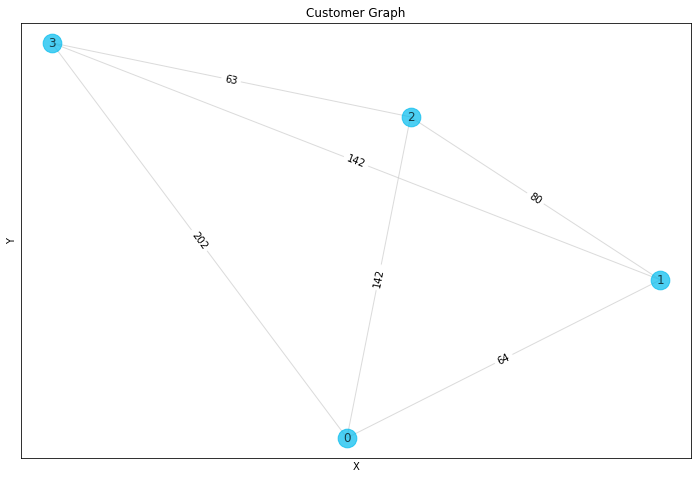

All Hamiltonian Paths from 0-3 :
 [[0, 1, 2, 3], [0, 2, 1, 3]] 

[0, 1, 2, 3]: 207
[0, 2, 1, 3]: 364
Minimum Cost for Zone 0: [0, 1, 2, 3] : 207

----For Zone 1----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 4: (951, 585), 5: (971, 518), 6: (1035, 744)}
{(0, 4): 178, (0, 5): 234, (0, 6): 287, (4, 5): 234, (4, 6): 253, (5, 6): 63}


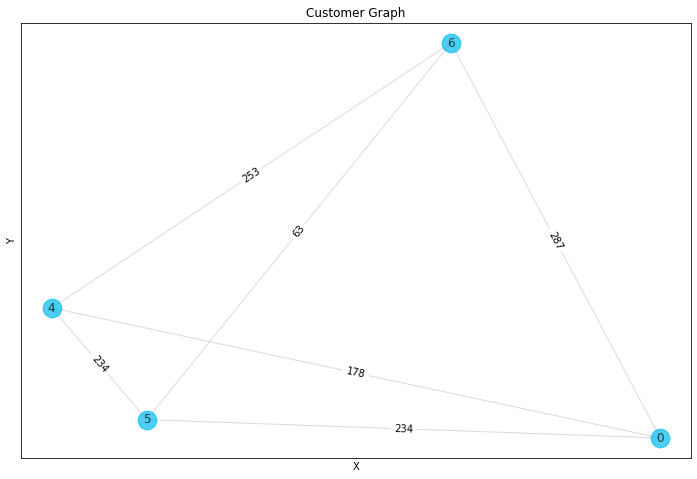

All Hamiltonian Paths from 0-6 :
 [[0, 4, 5, 6], [0, 5, 4, 6]] 

[0, 4, 5, 6]: 475
[0, 5, 4, 6]: 721
Minimum Cost for Zone 1: [0, 4, 5, 6] : 475

----For Zone 2----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 7: (978, 771), 8: (958, 710), 9: (873, 741)}
{(0, 7): 255, (0, 8): 341, (0, 9): 395, (7, 8): 90, (7, 9): 161, (8, 9): 78}


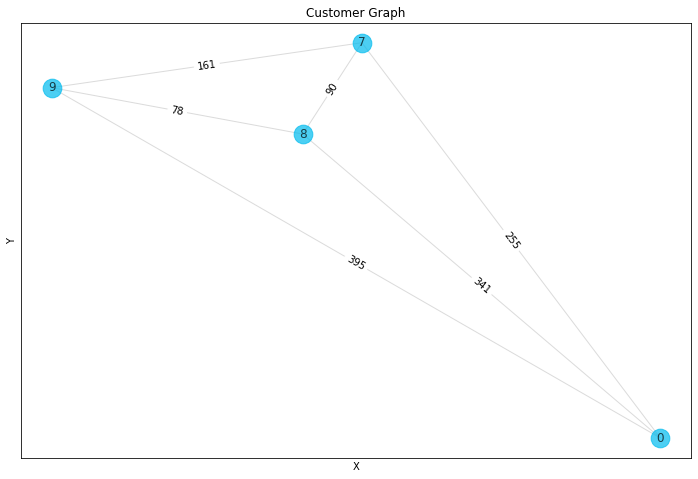

All Hamiltonian Paths from 0-9 :
 [[0, 7, 8, 9], [0, 8, 7, 9]] 

[0, 7, 8, 9]: 423
[0, 8, 7, 9]: 592
Minimum Cost for Zone 2: [0, 7, 8, 9] : 423

----For Zone 3----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 10: (797, 722), 11: (861, 674), 12: (780, 632)}
{(0, 10): 317, (0, 11): 379, (0, 12): 446, (10, 11): 91, (10, 12): 191, (11, 12): 100}


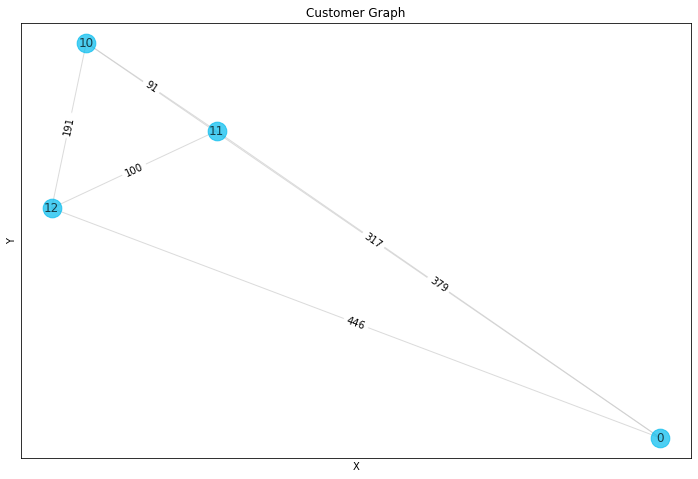

All Hamiltonian Paths from 0-12 :
 [[0, 10, 11, 12], [0, 11, 10, 12]] 

[0, 10, 11, 12]: 508
[0, 11, 10, 12]: 661
Minimum Cost for Zone 3: [0, 10, 11, 12] : 508

----For Zone 4----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 13: (702, 568), 14: (775, 569), 15: (659, 712)}
{(0, 13): 374, (0, 14): 518, (0, 15): 553, (13, 14): 184, (13, 15): 242, (14, 15): 64}


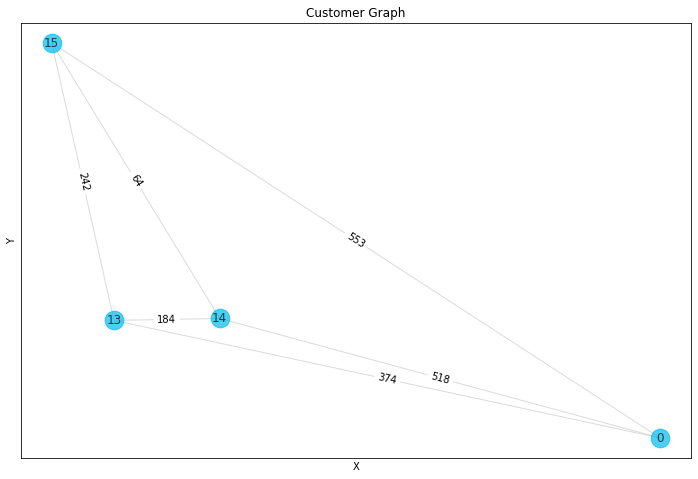

All Hamiltonian Paths from 0-15 :
 [[0, 13, 14, 15], [0, 14, 13, 15]] 

[0, 13, 14, 15]: 622
[0, 14, 13, 15]: 944
Minimum Cost for Zone 4: [0, 13, 14, 15] : 622

----For Zone 5----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 16: (647, 775), 17: (577, 773), 18: (550, 678)}
{(0, 16): 617, (0, 17): 613, (0, 18): 600, (16, 17): 98, (16, 18): 162, (17, 18): 66}


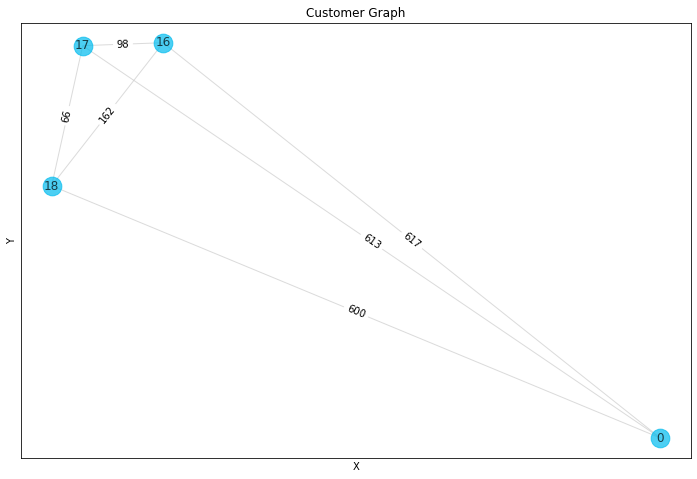

All Hamiltonian Paths from 0-18 :
 [[0, 16, 17, 18], [0, 17, 16, 18]] 

[0, 16, 17, 18]: 781
[0, 17, 16, 18]: 873
Minimum Cost for Zone 5: [0, 16, 17, 18] : 781

----For Zone 6----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 19: (552, 612), 20: (621, 638), 21: (431, 654)}
{(0, 19): 536, (0, 20): 726, (0, 21): 765, (19, 20): 190, (19, 21): 231, (20, 21): 72}


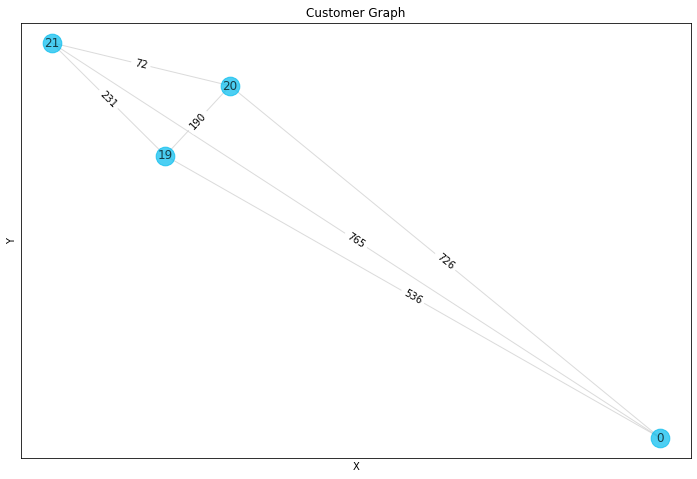

All Hamiltonian Paths from 0-21 :
 [[0, 19, 20, 21], [0, 20, 19, 21]] 

[0, 19, 20, 21]: 798
[0, 20, 19, 21]: 1147
Minimum Cost for Zone 6: [0, 19, 20, 21] : 798

----For Zone 7----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 22: (405, 722), 23: (340, 721), 24: (190, 726)}
{(0, 22): 828, (0, 23): 976, (0, 24): 1032, (22, 23): 150, (22, 24): 213, (23, 24): 68}


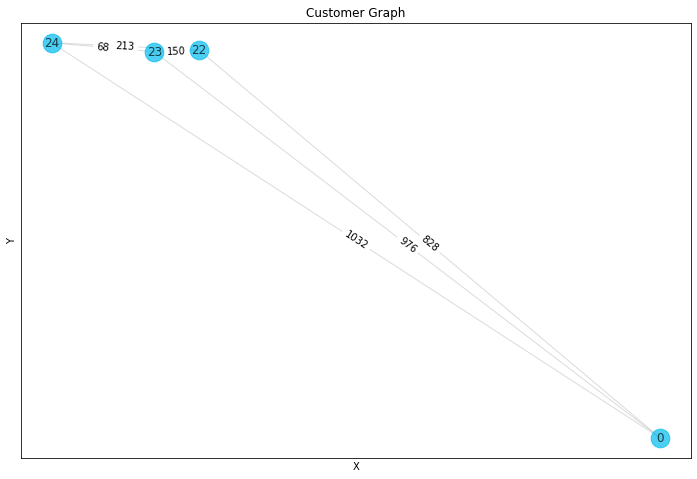

All Hamiltonian Paths from 0-24 :
 [[0, 22, 23, 24], [0, 23, 22, 24]] 

[0, 22, 23, 24]: 1046
[0, 23, 22, 24]: 1339
Minimum Cost for Zone 7: [0, 22, 23, 24] : 1046

----For Zone 8----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 25: (128, 697), 26: (189, 648), 27: (352, 510)}
{(0, 25): 965, (0, 26): 796, (0, 27): 859, (25, 26): 213, (25, 27): 164, (26, 27): 63}


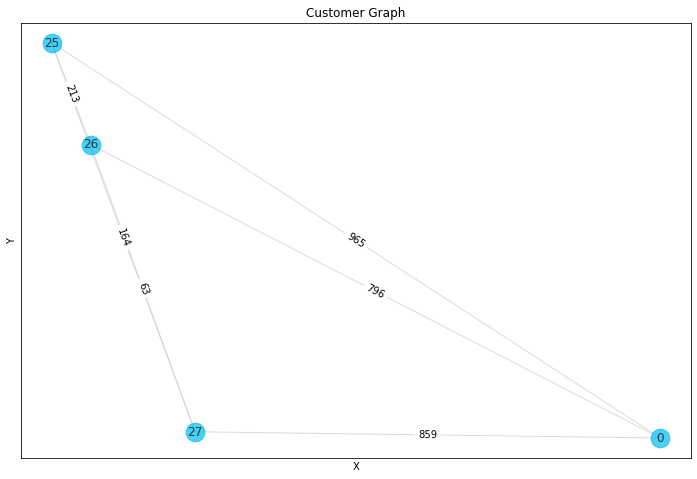

All Hamiltonian Paths from 0-27 :
 [[0, 25, 26, 27], [0, 26, 25, 27]] 

[0, 25, 26, 27]: 1241
[0, 26, 25, 27]: 1173
Minimum Cost for Zone 8: [0, 26, 25, 27] : 1173

----For Zone 9----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 28: (289, 518), 29: (284, 454), 30: (152, 413)}
{(0, 28): 868, (0, 29): 1003, (0, 30): 1060, (28, 29): 138, (28, 30): 194, (29, 30): 80}


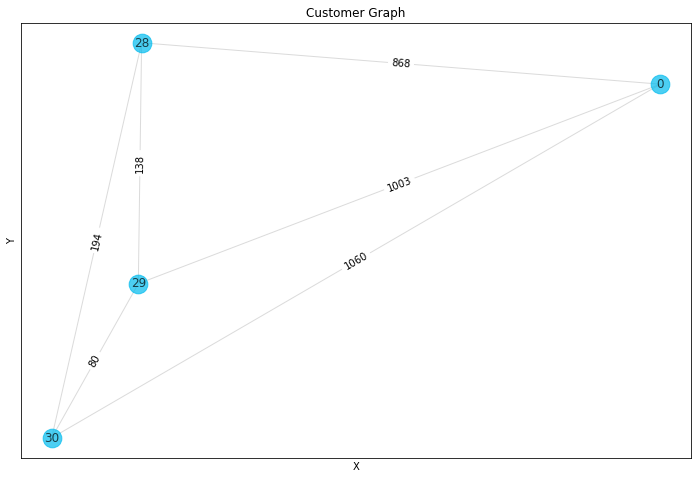

All Hamiltonian Paths from 0-30 :
 [[0, 28, 29, 30], [0, 29, 28, 30]] 

[0, 28, 29, 30]: 1086
[0, 29, 28, 30]: 1335
Minimum Cost for Zone 9: [0, 28, 29, 30] : 1086

----For Zone 10----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 31: (90, 465), 32: (71, 387), 33: (89, 220)}
{(0, 31): 1087, (0, 32): 1106, (0, 33): 1097, (31, 32): 167, (31, 33): 245, (32, 33): 80}


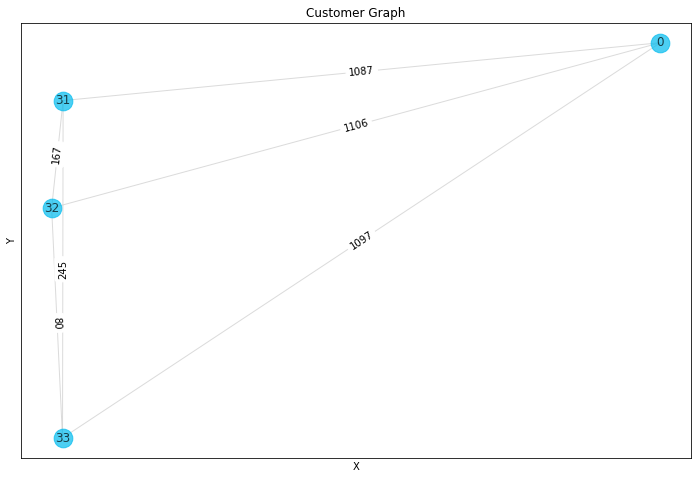

All Hamiltonian Paths from 0-33 :
 [[0, 31, 32, 33], [0, 32, 31, 33]] 

[0, 31, 32, 33]: 1334
[0, 32, 31, 33]: 1518
Minimum Cost for Zone 10: [0, 31, 32, 33] : 1334

----For Zone 11----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 34: (123, 147), 35: (158, 204), 36: (381, 181)}
{(0, 34): 1045, (0, 35): 846, (0, 36): 878, (34, 35): 224, (34, 36): 235, (35, 36): 63}


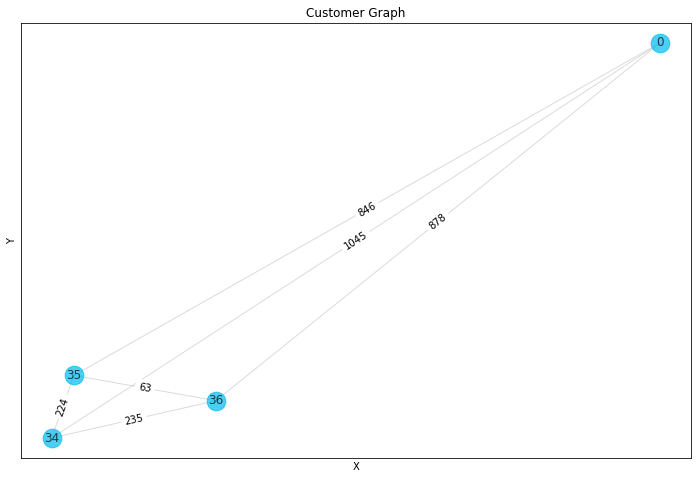

All Hamiltonian Paths from 0-36 :
 [[0, 34, 35, 36], [0, 35, 34, 36]] 

[0, 34, 35, 36]: 1332
[0, 35, 34, 36]: 1305
Minimum Cost for Zone 11: [0, 35, 34, 36] : 1305

----For Zone 12----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 37: (377, 118), 38: (438, 153), 39: (528, 54)}
{(0, 37): 808, (0, 38): 787, (0, 39): 740, (37, 38): 133, (37, 39): 195, (38, 39): 72}


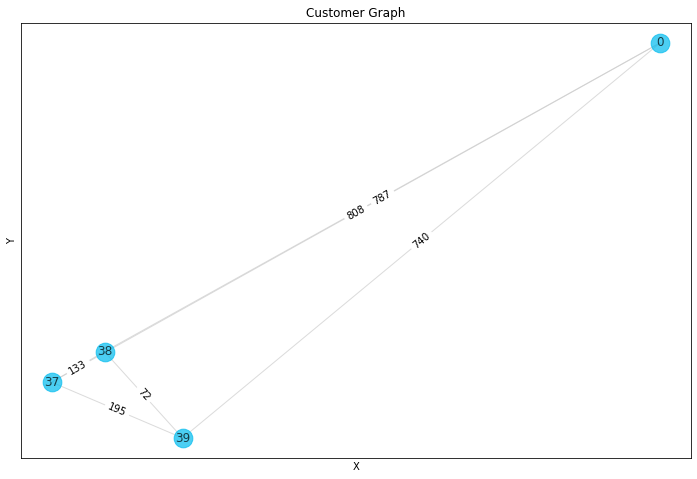

All Hamiltonian Paths from 0-39 :
 [[0, 37, 38, 39], [0, 38, 37, 39]] 

[0, 37, 38, 39]: 1013
[0, 38, 37, 39]: 1115
Minimum Cost for Zone 12: [0, 37, 38, 39] : 1013

----For Zone 13----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 40: (599, 42), 41: (598, 105), 42: (860, 104)}
{(0, 40): 700, (0, 41): 521, (0, 42): 603, (40, 41): 262, (40, 42): 226, (41, 42): 82}


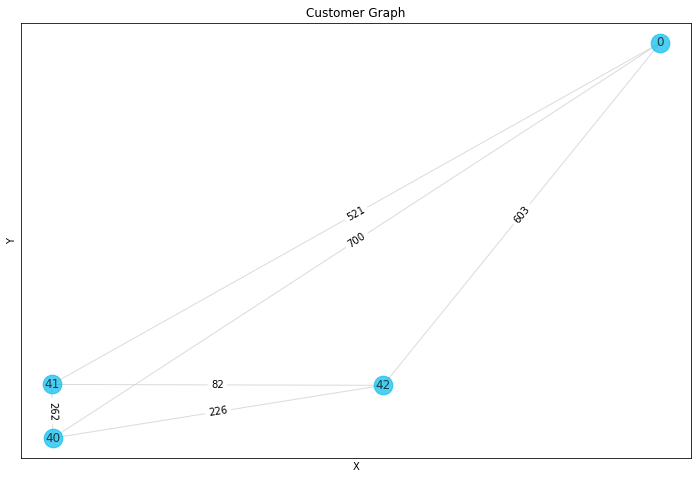

All Hamiltonian Paths from 0-42 :
 [[0, 40, 41, 42], [0, 41, 40, 42]] 

[0, 40, 41, 42]: 1044
[0, 41, 40, 42]: 1009
Minimum Cost for Zone 13: [0, 41, 40, 42] : 1009

----For Zone 14----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 43: (814, 36), 44: (894, 27), 45: (1070, 27)}
{(0, 43): 571, (0, 44): 517, (0, 45): 489, (43, 44): 176, (43, 45): 236, (44, 45): 63}


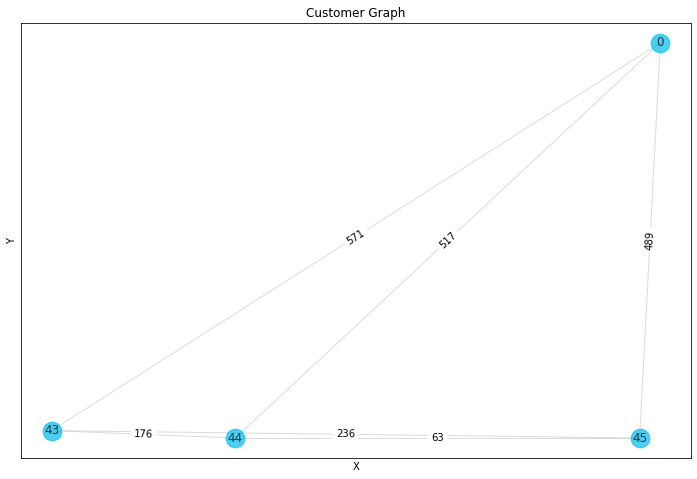

All Hamiltonian Paths from 0-45 :
 [[0, 43, 44, 45], [0, 44, 43, 45]] 

[0, 43, 44, 45]: 810
[0, 44, 43, 45]: 929
Minimum Cost for Zone 14: [0, 43, 44, 45] : 810

----For Zone 15----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 46: (1129, 50), 47: (1071, 95), 48: (1291, 122)}
{(0, 46): 450, (0, 47): 440, (0, 48): 503, (46, 47): 221, (46, 48): 263, (47, 48): 66}


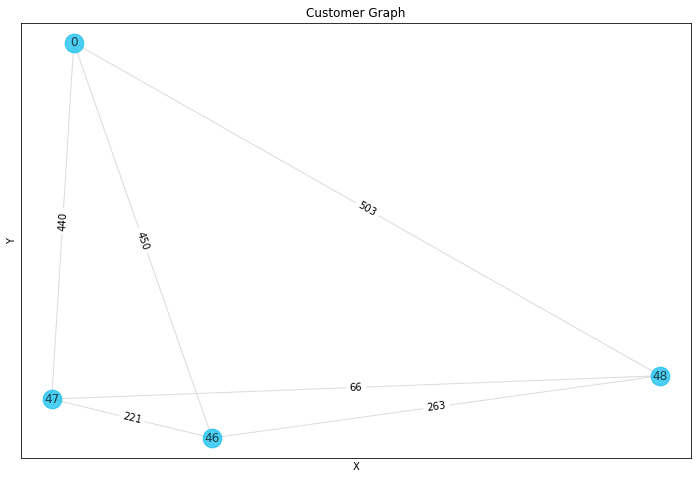

All Hamiltonian Paths from 0-48 :
 [[0, 46, 47, 48], [0, 47, 46, 48]] 

[0, 46, 47, 48]: 737
[0, 47, 46, 48]: 924
Minimum Cost for Zone 15: [0, 46, 47, 48] : 737

----For Zone 16----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 49: (1333, 71), 50: (1388, 111), 51: (1426, 167)}
{(0, 49): 490, (0, 50): 464, (0, 51): 395, (49, 50): 67, (49, 51): 134, (50, 51): 78}


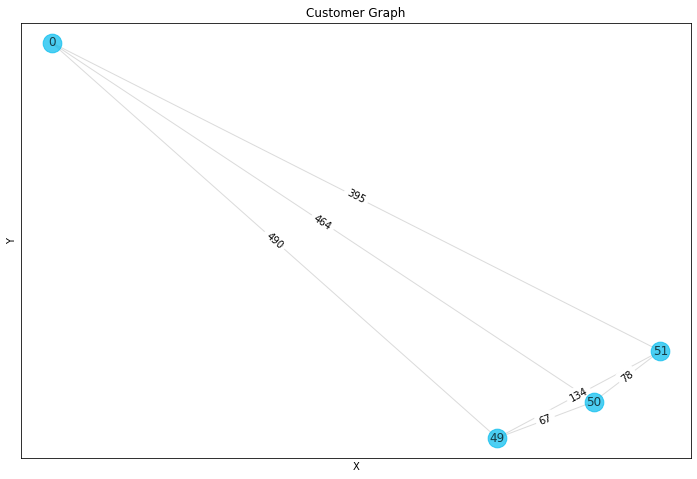

All Hamiltonian Paths from 0-51 :
 [[0, 49, 50, 51], [0, 50, 49, 51]] 

[0, 49, 50, 51]: 635
[0, 50, 49, 51]: 665
Minimum Cost for Zone 16: [0, 49, 50, 51] : 635

----For Zone 17----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 52: (1411, 244), 53: (1363, 285), 54: (1491, 490)}
{(0, 52): 332, (0, 53): 346, (0, 54): 422, (52, 53): 241, (52, 54): 291, (53, 54): 77}


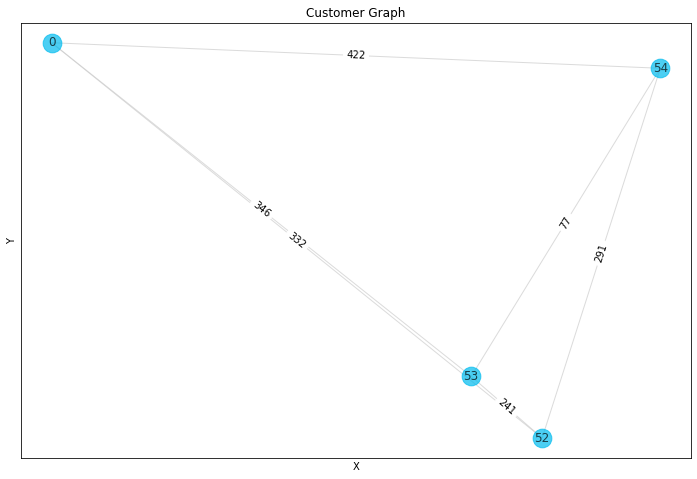

All Hamiltonian Paths from 0-54 :
 [[0, 52, 53, 54], [0, 53, 52, 54]] 

[0, 52, 53, 54]: 650
[0, 53, 52, 54]: 878
Minimum Cost for Zone 17: [0, 52, 53, 54] : 650

----For Zone 18----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 55: (1568, 492), 56: (1570, 555), 57: (1481, 696)}
{(0, 55): 422, (0, 56): 368, (0, 57): 342, (55, 56): 166, (55, 57): 226, (56, 57): 63}


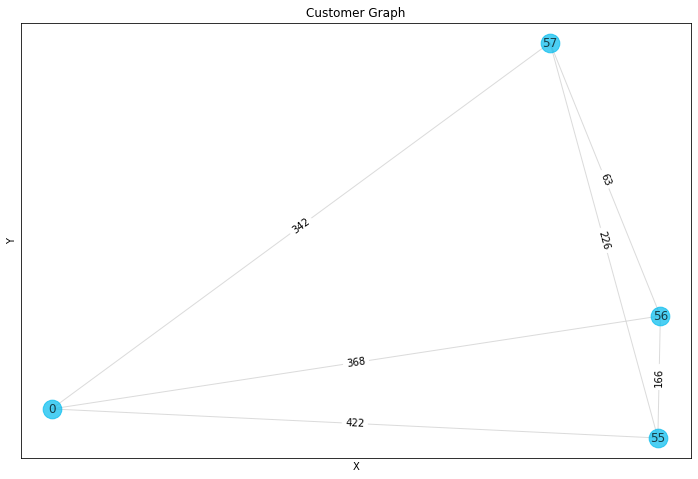

All Hamiltonian Paths from 0-57 :
 [[0, 55, 56, 57], [0, 56, 55, 57]] 

[0, 55, 56, 57]: 651
[0, 56, 55, 57]: 760
Minimum Cost for Zone 18: [0, 55, 56, 57] : 651

----For Zone 19----
distance matrix : 
 [[  0.          64.14047084 142.33762679 ... 342.28642976 285.39446386
  275.53584159]
 [ 64.14047084   0.          80.41144197 ... 373.48360071 312.37157361
  302.88281562]
 [142.33762679  80.41144197   0.         ... 440.87639991 377.93385665
  368.91733491]
 ...
 [342.28642976 373.48360071 440.87639991 ...   0.          63.95310782
   72.277244  ]
 [285.39446386 312.37157361 377.93385665 ...  63.95310782   0.
    9.89949494]
 [275.53584159 302.88281562 368.91733491 ...  72.277244     9.89949494
    0.        ]]
{0: (1079, 507), 58: (1430, 733), 59: (1367, 722), 60: (1360, 715)}


IndexError: index 60 is out of bounds for axis 0 with size 60

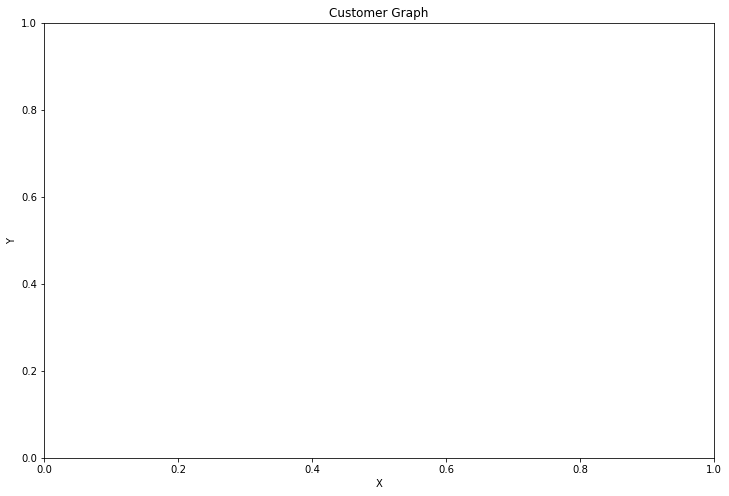

In [6]:
#Classical - Brute force solution
solutions=[]
instance=create_distance_matrix_for_zone(-1)
for zone_id in range(len(zones)):
    nodes_for_zone=zones[zone_id]
    #instance=create_distance_matrix_for_zone(zone_id)
    print ("\n----For Zone %s----"%zone_id)
    print ('distance matrix : \n',instance)
    X = nx.Graph()
    pos = {}
    plot_nodes(X,zone_id)
    selectedPaths = get_hamiltonian_paths(X,nodes_for_zone[3])
    print('All Hamiltonian Paths from 0-%s :\n'%nodes_for_zone[3],list(selectedPaths),'\n')
    min_cost, min_cost_path = get_min_cost_function(selectedPaths)
    print('Minimum Cost for Zone {}: {} : {}'.format(zone_id, min_cost_path, min_cost))
    
    #Create the adjacency matrix
    x=np.zeros((n,n), dtype=int)
    #for k in range(len(min_cost_path)-1):
    #    x[min_cost_path[k]][min_cost_path[k+1]]=1
    #x[min_cost_path[k+1]][0]=1
    #x=x.flatten()
    #print(x) 


    #draw_tsp_solution(X,min_cost_path,pos)
    solutions.append(min_cost_path)

In [8]:
def get_coordinates_array(xs,ys):
    coords=[[]] * len(xs)
    for i in range(len(xs)):
        coords[i]=([xs[i],ys[i]])
    return coords

def get_coordinates_array_for_zone(zone_id):
    coords=[[]] * 4
    zone_nodes=zones[zone_id]
    i=0
    for node in zone_nodes:
        coords[i]=(nodes[node]['x'],nodes[node]['y'])
        i=i+1
    return coords

def shift_solution_nodes(z, target_nodes):
    z2 = np.zeros(len(z), dtype=int)
    i = z.index(0)
    roll_by = len(z)-i
    z1 = np.roll(z,roll_by)
    for i in range(len(z)):
        z2[i] = target_nodes[z1[i]]
    return z2

def map_nodes(solution, target_nodes):
    mapped_solution=np.zeros(len(solution))
    for i in range(len(solution)):
        if (solution[i]==0):
            mapped_solution[i]=target_nodes[0]
        if (solution[i]==1):
            mapped_solution[i]=target_nodes[1]
        if (solution[i]==2):
            mapped_solution[i]=target_nodes[2]
        if (solution[i]==3):
            mapped_solution[i]=target_nodes[3]
    return mapped_solution.astype(int)

In [11]:
from qiskit.aqua.translators.ising import tsp
import sys
np.set_printoptions(threshold=1000)
#Store qubits for later use in VQE
qubitOps = []

def get_quantum_solution_for_zone(zone_id):
    #zone_id=4
    target_nodes = zones[zone_id]
    print('zone: ', zone_id, 'nodes: ', target_nodes)
    coord=get_coordinates_array_for_zone(zone_id)
    print (coord)
    zone_instance=create_distance_matrix_for_zone(zone_id)
    ins = tsp.TspData(name='AMC', dim=4, coord=coord, w=zone_instance)
    qubitOp, offset = tsp.get_tsp_qubitops(ins)
    qubitOps.append(qubitOp)
    algo_input = EnergyInput(qubitOp)
    #print('Paulis: ',qubitOp.aer_paulis,'\n')
    #print('Flat Paulis: ',qubitOp.get_flat_pauli_list(),'\n')
    #print('\nmatrix: ',qubitOp.matrix,'\n')
    print('num qubits: ',qubitOp.num_qubits,'\n')

    #Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()
    print('energy:', result['energy'])
    print('tsp objective:', result['energy'] + offset)
    print(result['eigvecs'])
    x = tsp.sample_most_likely(result['eigvecs'][0])
    print('feasible:', tsp.tsp_feasible(x))
    z = tsp.get_tsp_solution(x)
    print('solution:', z)
    print('solution objective:', tsp.tsp_value(z, ins.w))
    z2 = shift_solution_nodes(z, target_nodes)
    #z2=map_nodes(z2, target_nodes)
    #print('After Map: ',z2)
    #print(pos)
    #draw_tsp_solution(G, best_order, colors, pos)
    #draw_tsp_solution(X, z2, pos)
    return(z2)

In [12]:
instance=create_distance_matrix_for_zone(-1)
for zone_id in range(len(zones)):
    q_solution=get_quantum_solution_for_zone(zone_id)
    print('TSP soln for zone :',zone_id, ' - > ', q_solution)

zone:  0 nodes:  [0, 1, 2, 3]
[(1079, 507), (1148, 539), (1093, 572), (1014, 587)]
num qubits:  16 

energy: -1600741.3451961924
tsp objective: 323.6887409349438
[[0. 0. 0. ... 0. 0. 0.]]
feasible: True
solution: [3, 2, 1, 0]
solution objective: 323.688740934864
TSP soln for zone : 0  - >  [0 3 2 1]
zone:  1 nodes:  [0, 4, 5, 6]
[(1079, 507), (951, 585), (971, 518), (1035, 744)]
num qubits:  16 

energy: -1601368.9158312315
tsp objective: 599.3548265208956
[[0. 0. 0. ... 0. 0. 0.]]
feasible: True
solution: [0, 3, 1, 2]
solution objective: 599.3548265218574
TSP soln for zone : 1  - >  [0 6 4 5]
zone:  2 nodes:  [0, 7, 8, 9]
[(1079, 507), (978, 771), (958, 710), (873, 741)]
num qubits:  16 

energy: -1601470.5674453746
tsp objective: 718.6647844258696
[[0. 0. 0. ... 0. 0. 0.]]
feasible: True
solution: [1, 0, 2, 3]
solution objective: 718.6647844249834
TSP soln for zone : 2  - >  [0 8 9 7]
zone:  3 nodes:  [0, 10, 11, 12]
[(1079, 507), (797, 722), (861, 674), (780, 632)]
num qubits:  16 


In [38]:
seed = 10598
import logging
from qiskit.aqua import set_qiskit_aqua_logging
from qiskit.aqua.translators.ising.vehicle_routing import *
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
n=4
K=1
zone_id=1
#Get qubitOp for the zone
qubitOp = qubitOps[zone_id]
zone_instance=create_distance_matrix_for_zone(zone_id)
qubitOp = get_vehiclerouting_qubitops(zone_instance, n, K)
#Now we use the VQE that needs two algorithms as sub-components
#Sub-Component 1 : a local optimizer, we use SPSA/COBYLA(Constrained Optimization BY Linear Approximation) 
#from qiskit.aqua.components.optimizers
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
spsa = SPSA(max_trials=200)
#Sub-Component 2 : a variational form, we use Ry from qiskit.aqua.components.variational_forms
#ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
ry = RY(qubitOp.num_qubits, depth=3, entanglement='linear')
#vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe = VQE(qubitOp, ry, spsa, 'matrix')
vqe.random_seed = seed

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_transpiler=seed)

import time
start_time=time.time()
result = vqe.run(quantum_instance)
print("Ran For %s seconds" % (time.time() - start_time))
"""
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}
result = run_algorithm(parahms,algo_input)
"""

2019-10-24 08:56:37,556:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "disp": false,
    "maxiter": 1000,
    "rhobeg": 1.0,
    "tol": null
}
2019-10-24 08:56:37,557:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "cobyla_schema",
    "properties": {
        "disp": {
            "default": false,
            "type": "boolean"
        },
        "maxiter": {
            "default": 1000,
            "type": "integer"
        },
        "rhobeg": {
            "default": 1.0,
            "type": "number"
        },
        "tol": {
            "default": null,
            "type": [
                "number",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-10-24 08:56:37,558:qiskit.aqua.components.optimizers.optimizer:DEBUG: options: {'maxiter': 200, 'disp': False, 'rhobeg': 1.0}
2019-10-24 08:56:37,559:qiskit.aqua.parser.json_schema:DEBUG: Input: {
  

2019-10-24 08:56:37,566:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, change shots from 1024 to 1.
2019-10-24 08:56:37,567:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.10.0
Backend: 'statevector_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2019-10-24 08:56:37,567:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: When running with non-Aer statevector simulator, represent operator as a matrix could achieve the better performance. We convert the operator to matrix.
2019-10-24 08:56:37,592:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653

2019-10-24 08:56:43,896:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 28 returned 151581.8930195672
2019-10-24 08:56:44,110:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 29 returned 137803.47812994887
2019-10-24 08:56:44,298:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 30 returned 148238.53157899837
2019-10-24 08:56:44,299:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 15 of 25
2019-10-24 08:56:44,492:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 31 returned 142774.55026183283
2019-10-24 08:56:44,692:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 32 returned 146665.24845475482
2019-10-24 08:56:45,046:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 33 returned 139721.72555593023
2019-10-24 08:56:45,237:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 34 returned 148063.90522083122
2019-10-24 08:56:45,423:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 

2019-10-24 08:56:53,134:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 10: 112905.6684108
2019-10-24 08:56:53,135:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 10: 111569.8558118
2019-10-24 08:56:53,331:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 73 returned 111082.25851959854
2019-10-24 08:56:53,527:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 74 returned 113195.447384117
2019-10-24 08:56:53,529:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 111082.2585196
2019-10-24 08:56:53,530:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 113195.4473841
2019-10-24 08:56:53,752:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 75 returned 108897.86816305105
2019-10-24 08:56:53,980:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 76 returned 116295.63536543875
2019-10-24

2019-10-24 08:57:00,323:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 105 returned 102450.10251994056
2019-10-24 08:57:00,515:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 106 returned 103201.90515253288
2019-10-24 08:57:00,516:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 27: 102450.1025199
2019-10-24 08:57:00,517:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 27: 103201.9051525
2019-10-24 08:57:00,724:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 107 returned 105354.8850218257
2019-10-24 08:57:00,954:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 108 returned 100223.26622300729
2019-10-24 08:57:00,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: 105354.8850218
2019-10-24 08:57:00,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 28: 100223.2662230
2019-

2019-10-24 08:57:07,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: 98783.9240359
2019-10-24 08:57:07,961:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 139 returned 93948.22315539919
2019-10-24 08:57:08,161:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 140 returned 93052.20822252317
2019-10-24 08:57:08,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 93948.2231554
2019-10-24 08:57:08,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: 93052.2082225
2019-10-24 08:57:08,351:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 141 returned 92901.62315280568
2019-10-24 08:57:08,555:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 142 returned 93422.0592247247
2019-10-24 08:57:08,556:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 92901.6231528
2019-10-24 08

2019-10-24 08:57:15,003:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 60: 88746.9950408
2019-10-24 08:57:15,004:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 60: 80553.9910741
2019-10-24 08:57:15,201:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 173 returned 81148.1698157562
2019-10-24 08:57:15,396:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 174 returned 81544.56130903837
2019-10-24 08:57:15,397:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 61: 81148.1698158
2019-10-24 08:57:15,398:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 61: 81544.5613090
2019-10-24 08:57:15,585:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 175 returned 84226.03912209759
2019-10-24 08:57:15,776:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 176 returned 78840.8915413925
2019-10-24 08:

2019-10-24 08:57:22,888:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 206 returned 69746.99832138285
2019-10-24 08:57:22,890:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 69271.6550138
2019-10-24 08:57:22,890:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 69746.9983214
2019-10-24 08:57:23,161:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 207 returned 71439.82886559067
2019-10-24 08:57:23,376:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 208 returned 67873.04290404543
2019-10-24 08:57:23,378:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: 71439.8288656
2019-10-24 08:57:23,378:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 67873.0429040
2019-10-24 08:57:23,579:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 209 returned 67323.77494997674
2019-10-24 0

2019-10-24 08:57:29,944:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 239 returned 67868.7279579525
2019-10-24 08:57:30,170:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 240 returned 59540.43647584149
2019-10-24 08:57:30,172:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: 67868.7279580
2019-10-24 08:57:30,172:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 59540.4364758
2019-10-24 08:57:30,367:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 241 returned 61435.49600854874
2019-10-24 08:57:30,583:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 242 returned 62600.75853288839
2019-10-24 08:57:30,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: 61435.4960085
2019-10-24 08:57:30,585:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: 62600.7585329
2019-10-24 08

2019-10-24 08:57:37,020:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 58683.1991725
2019-10-24 08:57:37,232:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 273 returned 61263.82851080324
2019-10-24 08:57:37,451:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 274 returned 56033.02920256814
2019-10-24 08:57:37,452:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 61263.8285108
2019-10-24 08:57:37,453:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 56033.0292026
2019-10-24 08:57:37,777:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 275 returned 58378.55539796332
2019-10-24 08:57:37,962:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 276 returned 55948.97551397183
2019-10-24 08:57:37,963:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 58378.5553980
2019-10-

2019-10-24 08:57:44,224:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 306 returned 55655.58186148086
2019-10-24 08:57:44,225:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 127: 54322.7729525
2019-10-24 08:57:44,226:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 127: 55655.5818615
2019-10-24 08:57:44,420:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 307 returned 54092.062855715914
2019-10-24 08:57:44,608:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 308 returned 54651.77528261498
2019-10-24 08:57:44,609:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 54092.0628557
2019-10-24 08:57:44,610:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 54651.7752826
2019-10-24 08:57:44,801:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 309 returned 54211.64277000518
2019-10

2019-10-24 08:57:50,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 143: 53023.9574853
2019-10-24 08:57:51,124:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 339 returned 53973.621820560205
2019-10-24 08:57:51,312:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 340 returned 53514.19045861194
2019-10-24 08:57:51,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 144: 53973.6218206
2019-10-24 08:57:51,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 144: 53514.1904586
2019-10-24 08:57:51,504:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 341 returned 52168.78524079127
2019-10-24 08:57:51,689:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 342 returned 52793.55325048504
2019-10-24 08:57:51,690:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 145: 52168.7852408
2019-10

2019-10-24 08:57:57,897:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 372 returned 51916.20468557432
2019-10-24 08:57:57,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 160: 53462.5690502
2019-10-24 08:57:57,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 160: 51916.2046856
2019-10-24 08:57:58,090:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 373 returned 52725.58329852461
2019-10-24 08:57:58,282:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 374 returned 51577.34069874999
2019-10-24 08:57:58,283:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 161: 52725.5832985
2019-10-24 08:57:58,284:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 161: 51577.3406987
2019-10-24 08:57:58,470:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 375 returned 51101.06581161215
2019-10-

2019-10-24 08:58:05,264:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 405 returned 51767.98216774833
2019-10-24 08:58:05,479:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 406 returned 51721.38060729429
2019-10-24 08:58:05,480:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: 51767.9821677
2019-10-24 08:58:05,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: 51721.3806073
2019-10-24 08:58:05,848:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 407 returned 52154.36897434286
2019-10-24 08:58:06,102:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 408 returned 52638.029844805256
2019-10-24 08:58:06,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 178: 52154.3689743
2019-10-24 08:58:06,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 178: 52638.0298448
2019-10

2019-10-24 08:58:12,595:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 50520.3663049
2019-10-24 08:58:12,789:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 439 returned 51104.856743512646
2019-10-24 08:58:12,985:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 440 returned 50632.52018011081
2019-10-24 08:58:12,986:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 194: 51104.8567435
2019-10-24 08:58:12,987:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 194: 50632.5201801
2019-10-24 08:58:13,206:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 441 returned 52147.91169267595
2019-10-24 08:58:13,411:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 442 returned 51710.445482374795
2019-10-24 08:58:13,412:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 195: 52147.9116927
2019-1

Ran For 98.1881775856018 seconds


"\nalgorithm_cfg = {\n    'name': 'VQE',\n    'operator_mode': 'matrix'\n}\n\noptimizer_cfg = {\n    'name': 'SPSA',\n    'max_trials': 300\n}\n\nvar_form_cfg = {\n    'name': 'RY',\n    'depth': 5,\n    'entanglement': 'linear'\n}\n\nparams = {\n    'problem': {'name': 'ising', 'random_seed': seed},\n    'algorithm': algorithm_cfg,\n    'optimizer': optimizer_cfg,\n    'variational_form': var_form_cfg,\n    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}\n}\nresult = run_algorithm(parahms,algo_input)\n"

In [42]:
print(result)    
print('energy:', result['energy'])
print('time:', result['eval_time'])
quantum_solution = get_vehiclerouting_solution(zone_instance, n, K, result)
print(quantum_solution)
quantum_cost = get_vehiclerouting_cost(zone_instance, n, K, quantum_solution)
print(quantum_cost)

# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1
print(x_quantum)      
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
if (tsp.tsp_feasible(x)==True):
    z = tsp.get_tsp_solution(x)
    print('solution:', z)
    z2 = shift_solution_nodes(z)
    print(z2)
    print('solution objective:', tsp.tsp_value(z, ins.w))
    draw_tsp_solution(X, z2, pos)

{'num_optimizer_evals': None, 'min_val': 50002.45904969537, 'opt_params': array([-0.58638926, -2.79648271,  3.42161516, -0.24524913,  2.53534719,
        0.59074611,  0.04286186, -1.18202591,  0.24660953,  3.20275231,
       -1.34134407,  1.47819652,  2.80613648,  3.77320033, -2.20669564,
        3.07834788,  3.4385012 , -2.45359028,  1.16910012,  1.88740983,
        1.96557677,  1.74294083, -0.04570911,  1.9510664 ,  0.39044259,
       -0.06448222, -2.15628739,  0.90587925, -1.19292493, -0.01752723,
       -3.17240383,  0.05819586, -3.12200506,  0.13648071,  3.1530956 ,
       -1.49041448,  2.51910074,  0.45330708,  0.26875421, -1.25219839,
       -2.64006376, -2.78190771,  2.04074045, -0.9000473 , -0.42256094,
        1.44373735, -1.34421146,  1.89246417]), 'eval_time': 97.96609449386597, 'eval_count': 451, 'energy': 50002.45904969537, 'eigvals': array([50002.4590497]), 'min_vector': array([ 1.79865341e-05+0.j, -4.45819655e-06+0.j, -2.37002185e-04+0.j, ...,
       -1.23274313e-08+0.j

In [9]:
#Aggregation
#You will have 20 z arrays - 
#[[0,1,2,3], [0,7,6,8], [0,9,11,10]...]
#3, 8, 10, .... - with these create an array
edges = []
nodes_to_join = []
k=0
for solution in solutions:
#3 & 8 - whether their distance is less than threshold
    #Select nodes to join
    for i in range(len(solution)-1):
        edges.append([solution[i],solution[i+1],'#555555',1])
    print (solution)
    if k%2==0: #Even
        nodes_to_join.append(solution[3])
    else : #Odd
        nodes_to_join.append(solution[1])
        nodes_to_join.append(solution[3])
    k=k+1

print(nodes_to_join)
continue_joining=True
while(continue_joining):
    deleted=False
    for k in range(len(nodes_to_join)-1):
        nodeA=nodes_to_join[k]
        nodeB=nodes_to_join[k+1]
        distance = math.sqrt((nodes[nodeA]['x'] - nodes[nodeB]['x']) ** 2 + (nodes[nodeA]['y'] - nodes[nodeB]['y']) ** 2)
        print(nodeA,nodeB," --- ",distance)
        if distance < 100:
            edges.append([nodeA,nodeB,'#cc0000',2])
            nodes_to_join.remove(nodeA)
            nodes_to_join.remove(nodeB)
            deleted=True
            break
    print(nodes_to_join)
    if deleted==False:
        continue_joining=False

#if it is - the join 3-8 and remove 3,8 from the array
for k in range(len(nodes_to_join)):
    edges.append([nodes_to_join[k],0,'#0000cc',2])

[0, 1, 2, 3]
[0, 5, 4, 6]
[0, 8, 7, 9]
[0, 11, 10, 12]
[0, 14, 13, 15]
[0, 16, 17, 18]
[0, 20, 19, 21]
[0, 22, 23, 24]
[0, 25, 26, 27]
[0, 28, 29, 30]
[0, 31, 32, 33]
[0, 35, 34, 36]
[0, 38, 37, 39]
[0, 41, 40, 42]
[0, 43, 44, 45]
[0, 47, 46, 48]
[0, 49, 50, 51]
[0, 53, 52, 54]
[0, 55, 56, 57]
[0, 58, 59, 60]
[3, 5, 6, 9, 11, 12, 15, 16, 18, 21, 22, 24, 27, 28, 30, 33, 35, 36, 39, 41, 42, 45, 47, 48, 51, 53, 54, 57, 58, 60]
3 5  ---  81.30190649671138
[6, 9, 11, 12, 15, 16, 18, 21, 22, 24, 27, 28, 30, 33, 35, 36, 39, 41, 42, 45, 47, 48, 51, 53, 54, 57, 58, 60]
6 9  ---  162.02777539668932
9 11  ---  68.06614430096654
[6, 12, 15, 16, 18, 21, 22, 24, 27, 28, 30, 33, 35, 36, 39, 41, 42, 45, 47, 48, 51, 53, 54, 57, 58, 60]
6 12  ---  278.5121182282739
12 15  ---  145.0551619212498
15 16  ---  64.13267497929586
[6, 12, 18, 21, 22, 24, 27, 28, 30, 33, 35, 36, 39, 41, 42, 45, 47, 48, 51, 53, 54, 57, 58, 60]
6 12  ---  278.5121182282739
12 18  ---  234.5548976252681
18 21  ---  121.39604606411

In [10]:
def prepare_graph (graph):
    xs =[x0]; ys = [y0]
    nodelist=[]
    for i in range(len(xs_orig)):
        xs.append(xs_orig[i])
        ys.append(ys_orig[i])
        nodelist.append(i)
    nodelist.append(60)
    n=len(xs)
    keys = range(n)
    node_attrs_pos={}
    zones_array = np.array(zones)
    for i in nodelist:
        pos[i] = (xs[i], ys[i])
        if i==0:
            zone='HUB'
            name='HUB'
        else:
            result_tuple=np.where(zones_array==i)
            zone=result_tuple[0][0]
            name='N'+str(i)
        node_attrs_pos[i]={'name':name,'x':xs[i],'y':ys[i],'zone':zone}
    
    graph = graph.to_directed()
    #Add Nodes to graph
    graph.add_nodes_from(nodelist)
    #Set properties to nodes
    nx.set_node_attributes(graph,node_attrs_pos,'attrs')

    # Add Edges
    for edge in edges:
        graph.add_edge(edge[0], edge[1], color=edge[2], weight=edge[3])
    return graph

def plot_graph (graph):
    edges1 = graph.edges()
    colors = [graph[u][v]['color'] for u,v in edges1]
    weights = [graph[u][v]['weight'] for u,v in edges1]

    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(30,26)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')
    nx.draw_networkx(graph, pos, node_size=550, ax=ax,
                     edge_color=colors, width=weights,
                     node_color='#00bbee', alpha=0.7, with_labels=True)
    #labels = nx.get_edge_attributes(graph, "length")
    #print(labels)
    #nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    plt.grid(True)
    plt.show()

def print_data(graph):
    print(len(graph))
    for i in range(len(graph)):
        print(i,',',graph.nodes[i]['attrs']['name'],',',graph.nodes[i]['attrs']['zone'],
             ',',graph.nodes[i]['attrs']['x'],',',graph.nodes[i]['attrs']['y'])
    edges1 = graph.edges()
    for u,v in edges1:
        print (u,',',v,',',graph[u][v]['color'],',',graph[u][v]['weight'])

In [11]:
X = nx.Graph()
pos = {}
X= prepare_graph(X)
#plot_graph(X)
print_data(X)

61
0 , HUB , HUB , 1079 , 507
1 , N1 , 0 , 1148 , 539
2 , N2 , 0 , 1093 , 572
3 , N3 , 0 , 1014 , 587
4 , N4 , 1 , 951 , 585
5 , N5 , 1 , 971 , 518
6 , N6 , 1 , 1035 , 744
7 , N7 , 2 , 978 , 771
8 , N8 , 2 , 958 , 710
9 , N9 , 2 , 873 , 741
10 , N10 , 3 , 797 , 722
11 , N11 , 3 , 861 , 674
12 , N12 , 3 , 780 , 632
13 , N13 , 4 , 702 , 568
14 , N14 , 4 , 775 , 569
15 , N15 , 4 , 659 , 712
16 , N16 , 5 , 647 , 775
17 , N17 , 5 , 577 , 773
18 , N18 , 5 , 550 , 678
19 , N19 , 6 , 552 , 612
20 , N20 , 6 , 621 , 638
21 , N21 , 6 , 431 , 654
22 , N22 , 7 , 405 , 722
23 , N23 , 7 , 340 , 721
24 , N24 , 7 , 190 , 726
25 , N25 , 8 , 128 , 697
26 , N26 , 8 , 189 , 648
27 , N27 , 8 , 352 , 510
28 , N28 , 9 , 289 , 518
29 , N29 , 9 , 284 , 454
30 , N30 , 9 , 152 , 413
31 , N31 , 10 , 90 , 465
32 , N32 , 10 , 71 , 387
33 , N33 , 10 , 89 , 220
34 , N34 , 11 , 123 , 147
35 , N35 , 11 , 158 , 204
36 , N36 , 11 , 381 , 181
37 , N37 , 12 , 377 , 118
38 , N38 , 12 , 438 , 153
39 , N39 , 12 , 528 , 54
40 ,

In [98]:
#Solution with 3 nodes - remove
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.translators.ising.vehicle_routing import *

# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()
print (xc)
print (yc)
print (instance)
zone_id=19
xc,yc = get_xs_and_ys_for_a_zone(zone_id)
instance = create_distance_matrix_for_zone(zone_id)
print (xc)
print (yc)
print (instance, instance.shape)

[ 0.51003914  2.55963937 -0.64283509 -4.57068577]
[ 2.98724481 -2.72584275  1.05534574  0.79231007]
[[ 0.         36.84023052  5.061353   30.63150414]
 [36.84023052  0.         24.55322904 63.21893593]
 [ 5.061353   24.55322904  0.         15.49719877]
 [30.63150414 63.21893593 15.49719877  0.        ]]
[1079, 1430, 1367, 1360]
[507, 733, 722, 715]
[[  0.         417.46496859 359.40089037 349.60692213]
 [417.46496859   0.          63.95310782  72.277244  ]
 [359.40089037  63.95310782   0.           9.89949494]
 [349.60692213  72.277244     9.89949494   0.        ]] (4, 4)


In [99]:
qubitOp = get_vehiclerouting_qubitops(instance, n, K)
backend = BasicAer.get_backend('statevector_simulator')
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = vqe.run(quantum_instance)
# print(result)
x_quantum2 = get_vehiclerouting_solution(instance, n, K, result)
print(x_quantum2)
quantum_cost2 = get_vehiclerouting_cost(instance, n, K, x_quantum2)
print(quantum_cost2)

2019-10-24 11:15:20,502:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "disp": false,
    "maxiter": 1000,
    "rhobeg": 1.0,
    "tol": null
}
2019-10-24 11:15:20,503:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "cobyla_schema",
    "properties": {
        "disp": {
            "default": false,
            "type": "boolean"
        },
        "maxiter": {
            "default": 1000,
            "type": "integer"
        },
        "rhobeg": {
            "default": 1.0,
            "type": "number"
        },
        "tol": {
            "default": null,
            "type": [
                "number",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-10-24 11:15:20,505:qiskit.aqua.components.optimizers.optimizer:DEBUG: options: {'maxiter': 250, 'disp': False, 'rhobeg': 1.0}
2019-10-24 11:15:20,506:qiskit.aqua.parser.json_schema:DEBUG: Input: {
  

2019-10-24 11:15:20,540:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: COBYLA does not support bounds. It will be ignored.
2019-10-24 11:15:20,864:qiskit.aqua.utils.run_circuits:DEBUG: ==== Before transpiler ====
2019-10-24 11:15:20,867:qiskit.aqua.utils.run_circuits:DEBUG: Submitting 1 circuits.
0-th circuit: 12 qubits, 0 classical bits and 642 operations with depth 133
op_counts: OrderedDict([('u2', 396), ('cx', 198), ('u3', 48), ('barrier', 7)])

2019-10-24 11:15:20,867:qiskit.aqua.utils.run_circuits:DEBUG: ====  After transpiler ====
2019-10-24 11:15:20,868:qiskit.aqua.utils.run_circuits:DEBUG: Submitting 1 circuits.
0-th circuit: 12 qubits, 0 classical bits and 312 operations with depth 73
op_counts: OrderedDict([('cx', 198), ('u2', 66), ('u3', 48), ('barrier', 7)])

2019-10-24 11:15:20,962:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 1 returned 430375.6645585046
2019-10-24 11:15:21,538:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation

2019-10-24 11:15:47,808:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 62 returned 156259.78841070266
2019-10-24 11:15:48,363:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 63 returned 162141.053617277
2019-10-24 11:15:48,740:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 64 returned 162318.19872042822
2019-10-24 11:15:49,132:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 65 returned 140248.80687553596
2019-10-24 11:15:49,524:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 66 returned 126509.31712906384
2019-10-24 11:15:50,088:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 67 returned 145670.76362601243
2019-10-24 11:15:50,465:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 68 returned 144253.7389037653
2019-10-24 11:15:50,840:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 69 returned 163716.96336754892
2019-10-24 11:15:51,225:qiskit.aqua.algorithms.adap

2019-10-24 11:16:18,675:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 131 returned 84625.84958940546
2019-10-24 11:16:19,071:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 132 returned 82101.06275735416
2019-10-24 11:16:19,485:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 133 returned 79887.99252242877
2019-10-24 11:16:19,894:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 134 returned 85238.12075290419
2019-10-24 11:16:20,457:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 135 returned 78689.92457186582
2019-10-24 11:16:20,838:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 136 returned 79618.47845580784
2019-10-24 11:16:21,269:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 137 returned 82857.50616957335
2019-10-24 11:16:21,684:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 138 returned 77615.48379336314
2019-10-24 11:16:22,286:qiskit.aqua.algorithms.a

2019-10-24 11:16:49,448:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 200 returned 14436.507519387622
2019-10-24 11:16:49,839:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 201 returned 30989.969817914738
2019-10-24 11:16:50,232:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 202 returned 16717.962049797094
2019-10-24 11:16:50,778:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 203 returned 14826.877556870224
2019-10-24 11:16:51,176:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 204 returned 12413.533866036407
2019-10-24 11:16:51,552:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 205 returned 19534.483684610575
2019-10-24 11:16:51,942:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 206 returned 17147.773647446098
2019-10-24 11:16:52,519:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 207 returned 15334.681606295151
2019-10-24 11:16:52,895:qiskit.aqua.algo

[1 0 0 0 0 1 1 0 0 0 0 1]
859.0425978968851


[1079, 1430, 1367, 1360]
[507, 733, 722, 715]
x :  [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
{0: 1, 1: 3, 2: 0, 3: 2}
VQE soln for zone :  19  ->  [0, 58, 60, 59]


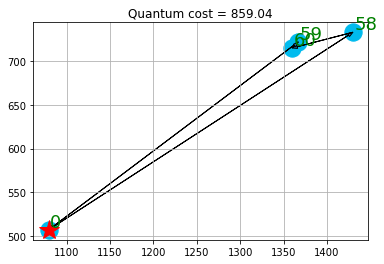

In [100]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=300, c='#00bbee')       #s -> marker size
    zone_nodes=zones[zone_id]
    for i in range(len(xc)):
        plt.annotate(zone_nodes[i], (xc[i] + 2, yc[i]+3), size=18, color='g')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()
    
    route_dict={}
    for ii in range(0, n ** 2):
        #print (ii, 'x: ',x[ii])
        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                      length_includes_head=True, head_width=4)
            #print('ix: ',ix, 'iy: ', iy)
            #print ('from: ', xc[ix], yc[ix], 'to: ',xc[ix]+xc[iy] - xc[ix], 'dy: ',yc[ix]+yc[iy] - yc[ix])
            route_dict[ix]=iy

    print(route_dict)
    route=[]
    for i in range(n):
        if (i==0): 
            route.append(0)
            key=i
        route.append(zone_nodes[route_dict[key]])
        key = route_dict[key]
    route=route[0:4]
    print('VQE soln for zone : ',zone_id,' -> ',route)   
    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = x_quantum2[kk]
        kk +=  1
print(xc)
print(yc)
print('x : ',x_quantum)
# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost2, n, K, 'Quantum')    